# Using `checkplotserver` for a variable star classification project

This notebook walks through using the `hatlc`, `periodbase`, and `checkplot` modules to generate *checkplots* for a collection of light curves. These checkplots are either PNG images or Python pickle files containing all the period-finding, light curve, and object information. These are meant to be easy to share with collaborators, and for use in reviewing large collections of light curves. There are two methods of reviewing checkplots provided in `astrobase`:

- For small collections of light curves and for very cursory review, use the 3 x 3 plot grids produced by `checkplot.checkplot_png` for a single period-finding method, or use the 3 x 3 plot grids produced by `checkplot.twolsp_checkplot_png` for two independent period-finding methods applied to a single object. The notebook `lightcurve-work.ipynb` in this folder discusses this method.

- For much larger collections of light curves, and for detailed reviewing, use the `checkplot.checkplot_pickle` function to produce pickles containing object, period-finding, and variability information for multiple period-finding methods per object. These pickles can be reviewed by `checkplotserver`, a Tornado webapp provided as part of the `astrobase` package, and discussed in this notebook. This allows adding in and saving comments, best periods and epochs, object type tags, and variability type tags for each object in the collection. All information can then be exported to CSV or JSON.

Below, we'll go through:

- reading the light curves
- running period-finding on these light curves
- generating checkplots after period-finding is done
- generating a file list for use with the `checkplotserver`
- reviewing objects, their light curves, and results of period-finding using the `checkplotserver`
- exporting all notes, tags, period and epoch information from the `checkplotserver` to CSV or JSON

## Reading light curves

Most `astrobase` modules operate on magnitude time series observations. These can be extracted from your own light curves. At a minimum, the information required is:

- a numpy ndarray of `times`
- a numpy ndarray of `mags`
- a numpy ndarray of `errs` associated with each `mags`

For this example, we'll use a collection of ten HAT survey light curves. These are in the "sqlitecurve" format and can be read, filtered, and normalized using the `astrobase.hatlc` module.

In [2]:
cd ~/scratch

/home/wbhatti/scratch


In [3]:
ls *.sqlite.gz

HAT-432-0007388-V0-DR0-hatlc.sqlite.gz  HAT-772-0219865-V0-DR0-hatlc.sqlite.gz
HAT-553-0087416-V0-DR0-hatlc.sqlite.gz  HAT-772-0302504-V0-DR0-hatlc.sqlite.gz
HAT-772-0212353-V0-DR0-hatlc.sqlite.gz  HAT-772-0554686-V0-DR0-hatlc.sqlite.gz
HAT-772-0215246-V0-DR0-hatlc.sqlite.gz  HAT-772-0562164-V0-DR0-hatlc.sqlite.gz
HAT-772-0215592-V0-DR0-hatlc.sqlite.gz  HAT-777-0058978-V0-DR0-hatlc.sqlite.gz


In [4]:
# import the astrobase modules

# for reading HAT light curves
from astrobase import hatlc

# for running period-finding on magnitude time-series observations
from astrobase import periodbase

# for generating checkplots to review object phased light curves, periods/epochs, and other info
from astrobase import checkplot

In [5]:
# here's how to read in a HAT sqlitecurve
lcd, msg = hatlc.read_and_filter_sqlitecurve('HAT-772-0554686-V0-DR0-hatlc.sqlite.gz')

2017-01-24T16:50:35.525455Z [INFO]: retrieving all latest columns
2017-01-24T16:50:35.525739Z [INFO]: no LC filters specified


In [6]:
# we can see all metadata using the hatlc.describe(lcdict) function
hatlc.describe(lcd)

OBJECT
------

objectid = HAT-772-0554686
hatid = HAT-772-0554686; twomassid = 14374811-5648595
network = HS; stations = HS02,HS04,HS06; ndet = 11261

ra = 219.450491; decl = -56.816551
pmra = 3.6; pmra_err = 2.9
pmdecl = -6.2; pmdecl_err = 2.9

jmag = 13.303; hmag = 12.65; kmag = 12.461; bmag = 17.744; vmag = 16.083
sdssg = 16.867; sdssr = 15.648; sdssi = 14.909

METADATA
--------

datarelease = 0; lcversion = 0
lastupdated = 1479866909.288; lcserver = 5b81c8c
comment = initial HS lightcurve creation
lcbestaperture = {"ap": ["002"], "ism": ["002"]}
lcsortcol = rjd
lcfiltersql = 
lcnormcols = 

CAMFILTERS
----------

7 - r - Sloan r AST0285
15 - r - Sloan r SN073 AST0285
23 - r - Sloan r SN081 AST0285

PHOTAPERTURES
-------------

000 - 2.05 px
001 - 3.00 px
002 - 4.00 px

LIGHT CURVE COLUMNS
-------------------

000 - rjd - time of observation in Reduced Julian date (JD = 2400000.0 + RJD)
001 - bjd - time of observation in Baryocentric Julian date (note: this is BJD_TDB)
002 - net - n

In [7]:
# we need times, magnitudes, and errors
# let's use RJD (the reduced Julian date = 2400000.0 - JD) for the times
# let's use the aperture photometry EPD (external parameter decorrelated) magnitude in aperture 000 (smallest) for mags
# let's use the instrumental mag error in aperture 000 as the errors
times, mags, errs = lcd['rjd'], lcd['aep_000'], lcd['aie_000']

In [8]:
# we can optionally normalize the magnitude time series observations to the global median
# this is useful for putting together light curves gathered from different instruments, filters, etc.
# for a single object, as is often the case for HAT survey light curves because we repeat observations in multiple seasons
normlcd = hatlc.normalize_lcdict(lcd)

/home/wbhatti/py3/lib/python3.6/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/home/wbhatti/py3/lib/python3.6/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [9]:
# get the normalized times, mags, errs as before. we'll use these going forward
ntimes, nmags, nerrs = normlcd['rjd'], normlcd['aep_000'], normlcd['aie_000']

## Running period-finding

The `astrobase.periodbase` contains several period finding methods that operate on `times`, `mags`, `errors` numpy ndarrays. If you can get these from your particular light curves, these methods should work successfully on them. In this case, we'll use these methods on the HAT light curve we read in above. The `periodbase` module contains the following period finding methods:

- Generalized Lomb-Scargle Periodogram (GLS; Zechmeister & Kurster 2009)
- Phase Dispersion Minimization (PDM; Stellingwerf 1978)
- Analysis of Variance (AoV; Schwarzenberg-Cerny 1989)
- Box-Least-Squares Fitting Search (BLS; Kovacs et al. 2002)

Using two or more of these on a single object can be a good way to check periodicity with independent methods. Below, we'll use the GLS, PDM, and BLS methods to see if the light curve we read in earlier has a periodic signal, and thus is from a variable star.

In [10]:
# run PDM on this light curve
# by default, the function will figure out a frequency grid automatically
# see the docstring for this function for details on how to set the start period, end period, and stepsize manually
pdm = periodbase.stellingwerf_pdm(times,mags,errs)

2017-01-24T17:05:55.594004Z [INFO]: sigclip = 10.0: before = 11261 observations, after = 10979 observations
2017-01-24T17:05:55.594859Z [INFO]: using autofreq with 41438 frequency points, start P = 0.100, end P = 828.843
2017-01-24T17:05:55.594956Z [INFO]: using 4 workers...


In [11]:
# the resulting object is a dictionary (common in format across all periodbase period-finding methods)
pdm

{'bestlspval': 0.50957429182173264,
 'bestperiod': 3.0857895588235325,
 'lspvals': array([ 0.99476289,  0.99635866,  0.99964712, ...,  1.00104481,
         1.00086542,  1.00105876]),
 'method': 'pdm',
 'nbestlspvals': [0.50957429182173264,
  0.570346484100276,
  0.67813526577633332,
  0.75682490593658969,
  0.77488117911330601],
 'nbestpeaks': 5,
 'nbestperiods': [3.0857895588235325,
  1.5428947794117662,
  6.1578237407132317,
  4.6304082430167641,
  7.7173470716946078],
 'periods': array([  8.28843076e+02,   6.90702563e+02,   5.92030768e+02, ...,
          1.00005197e-01,   1.00002784e-01,   1.00000371e-01])}

In [12]:
# the pdm['nbestperiods'] list contains the best five periods as determined from this method
pdm['nbestperiods']

[3.0857895588235325,
 1.5428947794117662,
 6.1578237407132317,
 4.6304082430167641,
 7.7173470716946078]

In [13]:
# the pdm['bestperiod'] value has the best period (in this case, with the smallest total dispersion)
pdm['bestperiod']

3.0857895588235325

In [14]:
# let's check this using another period-finding method: GLS
gls = periodbase.pgen_lsp(times,mags,errs)

2017-01-24T17:16:12.037847Z [INFO]: sigclip = 10.0: before = 11261 observations, after = 10979 observations
2017-01-24T17:16:12.038645Z [INFO]: using autofreq with 41438 frequency points, start P = 0.100, end P = 828.843
2017-01-24T17:16:12.038770Z [INFO]: using 4 workers...


In [15]:
# the gls dict is in the same format as pdm earlier
gls

{'bestlspval': 0.16292453306372998,
 'bestperiod': 1.5428947794117664,
 'lspvals': array([ 0.00253153,  0.00077572,  0.00058094, ...,  0.00012392,
         0.00012962,  0.00010454]),
 'method': 'gls',
 'nbestlspvals': [0.16292453306372998,
  0.089798983115883746,
  0.062605571343796615,
  0.057582441673332624,
  0.027127022400479862],
 'nbestpeaks': 5,
 'nbestperiods': [1.5428947794117664,
  0.77130381118555824,
  0.51423444316912825,
  3.0857895588235329,
  0.38547254929774016],
 'omegas': array([  7.58066936e-03,   9.09680323e-03,   1.06129371e-02, ...,
          6.28285877e+01,   6.28301038e+01,   6.28316199e+01]),
 'periods': array([  8.28843076e+02,   6.90702563e+02,   5.92030768e+02, ...,
          1.00005197e-01,   1.00002784e-01,   1.00000371e-01])}

In [16]:
# the best periods don't appear to entirely agree, however
gls['nbestperiods']

[1.5428947794117664,
 0.77130381118555824,
 0.51423444316912825,
 3.0857895588235329,
 0.38547254929774016]

In [17]:
# let's run another period finding method to make sure: BLS
# let's restrict the start period to 1.0 days to save some time
bls = periodbase.bls_parallel_pfind(times,mags,errs,startp=1.0)

2017-01-24T17:17:57.284780Z [INFO]: sigclip = 10.0: before = 11261 observations, after = 10979 observations
2017-01-24T17:17:57.284929Z [INFO]: autofreq: using stepsize: 3.01625250171e-06, min P: 1.0, max P: 100.0, nfreq: 328222, nphasebins: 200, min transit duration: 0.01, max transit duration: 0.8
2017-01-24T17:17:57.284997Z [INFO]: autofreq: minfreq: 0.01, maxfreq: 1.0
2017-01-24T17:17:57.285466Z [INFO]: using 4 workers...
2017-01-24T17:17:57.290141Z [INFO]: worker 1: minfreq = 0.010, nfreqs = 82056
2017-01-24T17:17:57.290366Z [INFO]: worker 2: minfreq = 0.258, nfreqs = 82056
2017-01-24T17:17:57.290425Z [INFO]: worker 3: minfreq = 0.505, nfreqs = 82056
2017-01-24T17:17:57.290479Z [INFO]: worker 4: minfreq = 0.753, nfreqs = 82054
2017-01-24T17:17:57.290531Z [INFO]: running...


In [19]:
# let's see the best periods list
bls['nbestperiods']

[3.0856065504766148,
 1.5427700518091203,
 6.171306589669304,
 9.2565832017969942,
 4.6283156559753316]

This looks like an eclipsing binary; the GLS method usually finds a harmonic associated with the actual period. We need a way to incorporate all of these period-finding methods into a review method so we can decided what looks right for this object. For this, we'll turn to the checkplot module.

## Making checkplot pickles

Since this is a single object, we could just use the `checkplot.checkplot_png` function along with one of the `gls`, `pdm`, or `bls` dicts above to generate PNGs for review. But these are hard to add notes to if we're reviewing lots of them. Instead, let's use the `checkplot.checkplot_pickle` function to generate a checkplot pickle, which we can review later using the `checkplotserver` webapp.

In [20]:
# make a checkplot pickle for this object.
# the inputs are a list of results from the period-finding methods above; the times, mags, and errs arrays; and 
# the objectinfo dict from the HAT light curve. see the docstring for this function to see what this should look
# like for your own light curves. at a minimum: an objectid (a string), and the object's right ascension and declination
# are required to generate a finding chart. this is entirely optional, so leave it out if you don't want one.
cpf = checkplot.checkplot_pickle([gls,pdm,bls], 
                                 times, mags, errs, 
                                 objectinfo=lcd['objectinfo'], 
                                 outfile='checkplot-%s.pkl' % lcd['objectid'])

2017-01-24T17:27:32.153743Z [INFO]: adding in object information and finder chart for HAT-772-0554686 at RA: 219.450, DEC: -56.817


/home/wbhatti/py3/lib/python3.6/site-packages/astroquery/utils/commons.py:187: UserWarning: Coordinate string is being interpreted as an ICRS coordinate.
  warnings.warn("Coordinate string is being interpreted as an "


2017-01-24T17:27:33.045090Z [INFO]: sigclip = 4.0: before = 11261 observations, after = 10557 observations
2017-01-24T17:27:34.192778Z [INFO]: sigclip = 30.0: before = 10557 observations, after = 10557 observations
2017-01-24T17:27:34.197772Z [INFO]: spline fit done. nknots = 100,  chisq = 26292.31502, reduced chisq = 2.51457
2017-01-24T17:27:34.198066Z [INFO]: plotting gls phased LC with period 0: 1.542895, epoch: 56833.32172
2017-01-24T17:27:35.685484Z [INFO]: sigclip = 30.0: before = 10557 observations, after = 10557 observations
2017-01-24T17:27:35.689853Z [INFO]: spline fit done. nknots = 100,  chisq = 37106.69344, reduced chisq = 3.54884
2017-01-24T17:27:35.690066Z [INFO]: plotting gls phased LC with period 1: 0.771304, epoch: 56798.59759
2017-01-24T17:27:37.197919Z [INFO]: sigclip = 30.0: before = 10557 observations, after = 10557 observations
2017-01-24T17:27:37.202347Z [INFO]: spline fit done. nknots = 100,  chisq = 38723.51531, reduced chisq = 3.70347
2017-01-24T17:27:37.2024

In [21]:
# the output pickle now contains a dict with all of the useful info
# we can read this in if needed
cpdict = checkplot._read_checkplot_picklefile(cpf)

In [22]:
# look at the keys of the dict
cpdict.keys()

dict_keys(['objectid', 'objectinfo', 'finderchart', 'sigclip', 'normto', 'normmingap', 'varinfo', 'magseries', 'gls', 'pdm', 'bls', 'status', 'comments'])

In [23]:
# some details for the object
cpdict['objectinfo']

{'bmag': 17.744,
 'bvcolor': 1.6610000000000014,
 'decl': -56.816551,
 'hatid': 'HAT-772-0554686',
 'hmag': 12.65,
 'ijcolor': 1.6059999999999999,
 'jkcolor': 0.8420000000000005,
 'jmag': 13.303,
 'kmag': 12.461,
 'ndet': 11261,
 'network': 'HS',
 'objecttags': None,
 'pmdecl': -6.2,
 'pmdecl_err': 2.9,
 'pmra': 3.6,
 'pmra_err': 2.9,
 'propermotion': 6.5055597815287713,
 'ra': 219.450491,
 'reducedpropermotion': 2.369423360421397,
 'sdssg': 16.867,
 'sdssi': 14.909,
 'sdssr': 15.648,
 'stations': 'HS02,HS04,HS06',
 'twomassid': '14374811-5648595 ',
 'ucac4id': '21965424',
 'vmag': 16.083}

In [24]:
# some variability information, which is currently blank since we haven't reviewed this object yet
# this is what will be added in using the checkplotserver interface, along with cpdict['comments']
cpdict['varinfo']

{'objectisvar': None,
 'varepoch': None,
 'varisperiodic': None,
 'varperiod': None,
 'vartags': None}

Now that we have done this procedure for a single object, we can repeat it for the rest of the light curves in our collection. Here's a function to do just that.

In [33]:
def makecp(lcfile, timecol, magcol, errcol, startperiod=0.1, endperiod=100.0, freqstep=None):
    
    # read and normalize the light curve
    lcd, msg = hatlc.read_and_filter_sqlitecurve(lcfile)
    normlcd = hatlc.normalize_lcdict(lcd)

    # get the times, mags, and errs
    times, mags, errs = normlcd[timecol], normlcd[magcol], normlcd[errcol]

    # run the various period finders (GLS, PDM, BLS)
    gls = periodbase.pgen_lsp(times, mags, errs, startp=startperiod, endp=endperiod, stepsize=freqstep)
    pdm = periodbase.stellingwerf_pdm(times, mags, errs, startp=startperiod, endp=endperiod, stepsize=freqstep)
    bls = periodbase.bls_parallel_pfind(times, mags, errs, startp=startperiod, endp=endperiod, stepsize=freqstep)
    # adding another period-finding result will crowd the display, so it's disabled here. 
    # if you have a giant monitor with 4K resolution, feel free to enable this. 
    # aov = periodbase.pgen_lsp(times, mags, errs, startp=startperiod, endp=endperiod, freqstep=freqstep)
    
    # generate a checkplot
    cpf = checkplot.checkplot_pickle([gls, pdm, bls],
                                     times, mags, errs,
                                     objectinfo=lcd['objectinfo'],
                                     outfile='checkplot-%s.pkl' % lcd['objectid'])
    
    return cpf

In [34]:
# let's test this for a single object
cpfile = makecp('HAT-772-0554686-V0-DR0-hatlc.sqlite.gz','rjd','aep_000','aie_000')

2017-01-24T17:50:42.747395Z [INFO]: retrieving all latest columns
2017-01-24T17:50:42.747542Z [INFO]: no LC filters specified
2017-01-24T17:50:43.383754Z [INFO]: sigclip = 10.0: before = 11261 observations, after = 10979 observations
2017-01-24T17:50:43.384518Z [INFO]: using autofreq with 41401 frequency points, start P = 0.100, end P = 100.000
2017-01-24T17:50:43.384557Z [INFO]: using 4 workers...


/home/wbhatti/py3/lib/python3.6/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/home/wbhatti/py3/lib/python3.6/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


2017-01-24T17:50:58.632615Z [INFO]: sigclip = 10.0: before = 11261 observations, after = 10979 observations
2017-01-24T17:50:58.633411Z [INFO]: using autofreq with 41401 frequency points, start P = 0.100, end P = 100.000
2017-01-24T17:50:58.633529Z [INFO]: using 4 workers...
2017-01-24T17:51:31.449556Z [INFO]: sigclip = 10.0: before = 11261 observations, after = 10979 observations
2017-01-24T17:51:31.449726Z [INFO]: autofreq: using stepsize: 3.01625250171e-06, min P: 0.1, max P: 100.0, nfreq: 3312057, nphasebins: 200, min transit duration: 0.01, max transit duration: 0.8
2017-01-24T17:51:31.449758Z [INFO]: autofreq: minfreq: 0.01, maxfreq: 10.0
2017-01-24T17:51:31.450388Z [INFO]: using 4 workers...
2017-01-24T17:51:31.502108Z [INFO]: worker 1: minfreq = 0.010, nfreqs = 828015
2017-01-24T17:51:31.502215Z [INFO]: worker 2: minfreq = 2.508, nfreqs = 828015
2017-01-24T17:51:31.502375Z [INFO]: worker 3: minfreq = 5.005, nfreqs = 828015
2017-01-24T17:51:31.502414Z [INFO]: worker 4: minfreq =

/home/wbhatti/py3/lib/python3.6/site-packages/astroquery/utils/commons.py:187: UserWarning: Coordinate string is being interpreted as an ICRS coordinate.
  warnings.warn("Coordinate string is being interpreted as an "


2017-01-24T17:55:15.914504Z [INFO]: sigclip = 4.0: before = 11261 observations, after = 10565 observations
2017-01-24T17:55:16.875680Z [INFO]: sigclip = 30.0: before = 10565 observations, after = 10565 observations
2017-01-24T17:55:16.880006Z [INFO]: spline fit done. nknots = 100,  chisq = 26910.50969, reduced chisq = 2.57172
2017-01-24T17:55:16.880403Z [INFO]: plotting gls phased LC with period 0: 1.542641, epoch: 56857.97573
2017-01-24T17:55:18.316288Z [INFO]: sigclip = 30.0: before = 10565 observations, after = 10565 observations
2017-01-24T17:55:18.320788Z [INFO]: spline fit done. nknots = 100,  chisq = 37134.14316, reduced chisq = 3.54875
2017-01-24T17:55:18.320876Z [INFO]: plotting gls phased LC with period 1: 0.771384, epoch: 56794.76227
2017-01-24T17:55:19.761659Z [INFO]: sigclip = 30.0: before = 10565 observations, after = 10565 observations
2017-01-24T17:55:19.765917Z [INFO]: spline fit done. nknots = 100,  chisq = 39085.79154, reduced chisq = 3.73526
2017-01-24T17:55:19.7660

Looks good.

You can run this function for all of the light curves in your collection. It's fairly parallelizable, so you may want to use a `concurrent.futures ProcessPoolExecutor`, `joblib`, `ipyparallel`, `dask.distributed`, or your favorite parallel execution engine (SGE, SLURM) to run this if you have thousands of light curves. Once you have a collection of checkplot pickles, proceed to the next step: making an input list for the `checkplotserver`.

## Generating an input JSON file for `checkplotserver`

Before the `checkplotserver` webapp can work on your collection of light curves, it needs to know where all the checkplot pickles you produced are. We use the `checkplotlist` script for this. If `astrobase` was installed in a Python virtualenv, and this virtualenv is activated, the `checkplotlist` script should be in your $PATH. If it is, invoke it like so:

```bash
$ cd /path/to/where/checkplots/are/
$ checkplotlist pkl .
```

If it's not, you can run it like so:

```bash
$ cd /path/to/where/checkplots/are/
$ python /path/to/where/you/installed/astrobase/astrobase/checkplotlist.py pkl .
```

This produces a JSON file `checkplot-filelist.json` that contains the paths to the checkplot pickles. An example for the ten light curves we listed above:

```json
{"checkplots": ["./checkplot-HAT-432-0007388.pkl", "./checkplot-HAT-553-0087416.pkl", "./checkplot-HAT-772-0212353.pkl", "./checkplot-HAT-772-0215246.pkl", "./checkplot-HAT-772-0215592.pkl", "./checkplot-HAT-772-0219865.pkl", "./checkplot-HAT-772-0302504.pkl", "./checkplot-HAT-772-0554686.pkl", "./checkplot-HAT-772-0562164.pkl", "./checkplot-HAT-777-0058978.pkl"], "nfiles": 10}
```

Now, we can start up the `checkplotserver` and review all of these light curves.

## Starting up and using `checkplotserver`

To start the webapp; if it's in your $PATH due to the virtualenv being active:

```bash
$ cd /path/to/where/the/checkplots/are/
$ checkplotserver
```

Alternatively; if it's not in your path:

```bash
$ cd /path/to/where/the/checkplots/are
$ python /path/to/where/you/installed/astrobase/astrobase/checkplotserver.py
```

If invoked without any arguments, the app will search in the directory it was started for a `checkplot-filelist.json` file, read this in, and bring up the interface. Help on the command-line arguments is available:

```
$ checkplotserver --help
Usage: /home/wbhatti/py3/bin/checkplotserver [OPTIONS]

Options:

  --help                           show this help information

/home/wbhatti/astrowork/astrobase/astrobase/checkplotserver.py options:

  --assetpath                      Sets the asset (server images, css, js, DB)
                                   path for checkplotserver. (default /home/wbh
                                   atti/astrowork/astrobase/astrobase/data/cps-
                                   assets)
  --checkplotlist                  The path to the checkplot-filelist.json file
                                   listing checkplots to load and serve. If
                                   this is not provided, checkplotserver will
                                   look for a checkplot-pickle-flist.json in
                                   the directory that it was started in
  --debugmode                      start up in debug mode if set to 1. (default
                                   0)
  --maxprocs                       number of background processes to use for
                                   saving/loading checkplot files (default 1)
  --port                           Run on the given port. (default 5225)
  --serve                          Bind to given address and serve content.
                                   (default 127.0.0.1)
                                   
... Tornado-specific options below ...
```

Let's start up the `checkplotserver` for these light curves:

```
$ checkplotserver
[W 170124 13:07:38 checkplotserver:162] No checkplot list file provided!
    (use --checkplotlist=... for this, or use --help to see all options)
    looking for checkplot-filelist.json in the current directory /home/wbhatti/scratch ...
[I 170124 13:07:38 checkplotserver:169] using checkplot list file: /home/wbhatti/scratch/checkplot-filelist.json
[I 170124 13:07:38 checkplotserver:260] started checkplotserver. listening on http://127.0.0.1:5225
```

Browse to the address specified to get to the interface. An example of what it looks like is shown below:

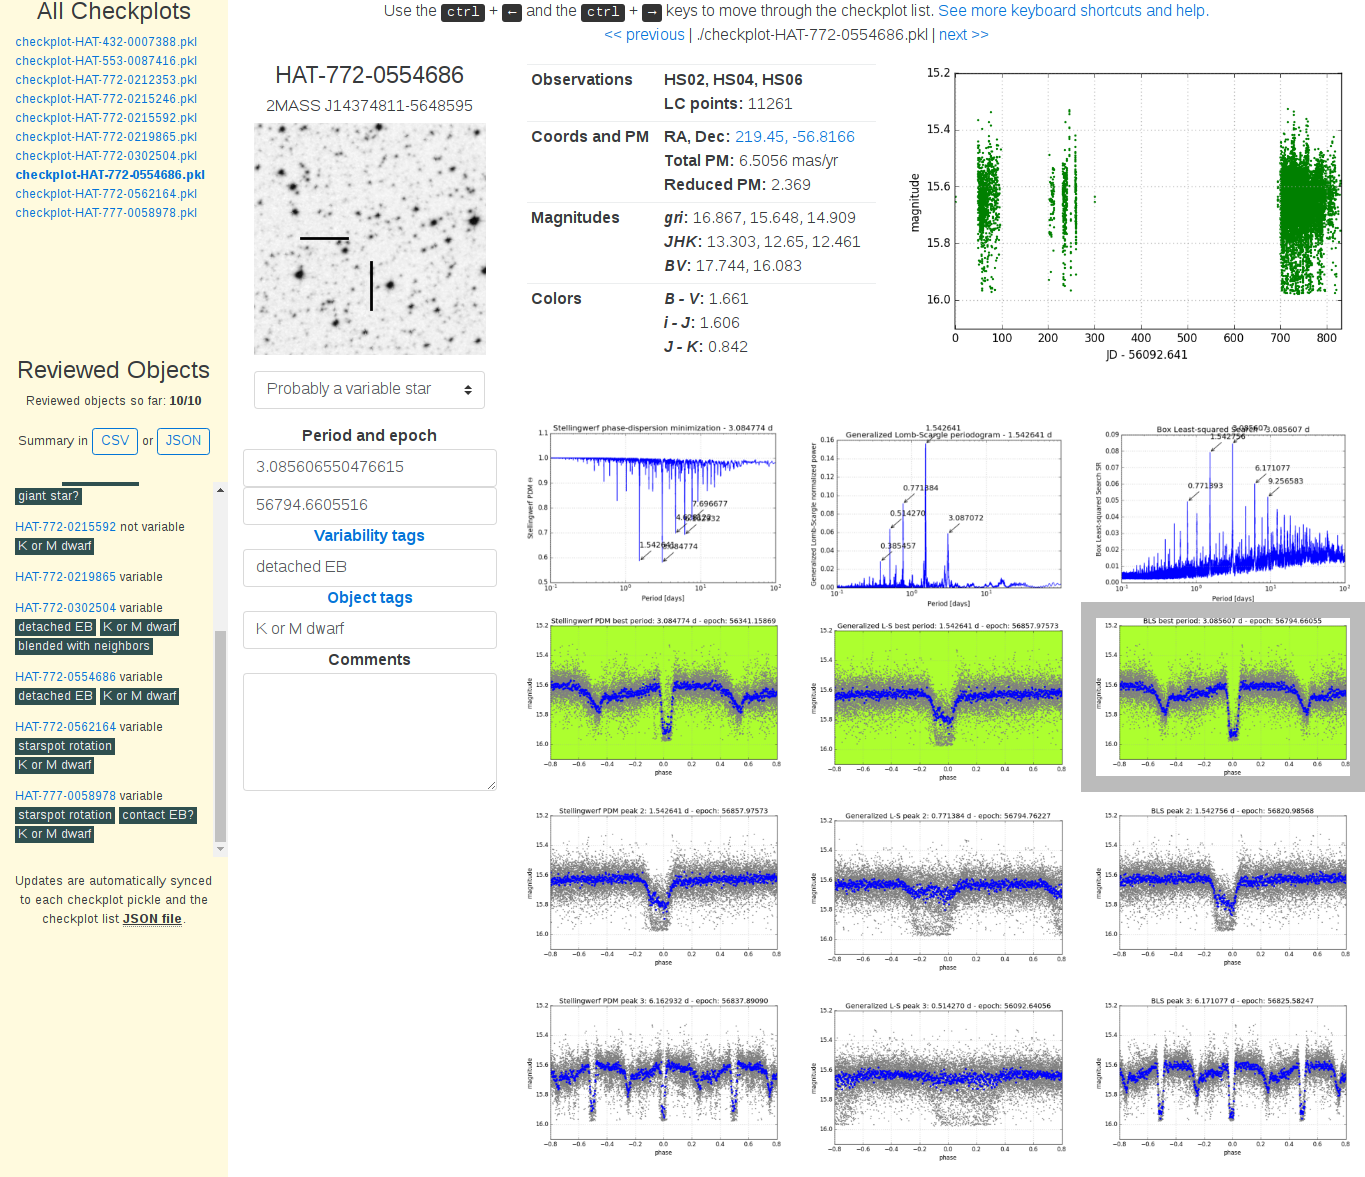

In [1]:
from IPython.display import Image
Image('/home/wbhatti/astrowork/astrobase/astrobase/data/checkplotserver.png')

(So it turns out that the object we looked at the beginning of this notebook was an eclipsing binary after all.)

Going through the items in the `checkplotserver` interface:

- _Top-left_: a list of the checkplot pickles loaded from the checkplot-filelist.json file. Click on any file to jump to it. Whenever you move from one checkplot to another, the app will automatically save all changes you made (if any) to the previous checkplot pickle.

- _Top_: a navigation bar with "prev" and "next" links to move through the checkplot list. A brief help and keyboard shortcut list is available by clicking on the "See more keyboard shortcuts and help" link. The keyboard shortcuts allow quick tagging, selection of best periods and epochs, and movement through the checkplot list. A list of these is given below.

- _Bottom-left_: a list of objects that have been reviewed as you move through the checkplot list. This is automatically updated whenever you move from one checkplot to another, and contains a quick overview of objects, their variability and object type tags, and whether or not they were noted as actually variable, based on your inputs. The list can be exported to CSV or JSON by clicking the appropriate links.

- _Center-left_: the finder chart for the object, and input boxes for flagging this object as a variable, its best period and epoch as chosen from the grid of the phased light curve plots on the center-right, input boxes for variability tags and object tags, and a text box for free-form comments. The tag input boxes have a list of default tags that can be chosen from by clicking on the respective "Variability tags" or "Object tags" links, but you can type in your own tags as appropriate, separated by commas.

- _Center-top_: basic object information from the light curve, including magnitudes, colors, and proper motion. The panel on the right shows the unphased light curve of the object, using the time and magnitude columns that you selected when you made the checkplot pickle.

- _Center-right_: a grid of plots showing the periodograms (top panels) and phased light curve plots using the best 3 periods in the periodogram (next 3 rows; the best overall period found by the period-search is highlighted), for each period-search method in separate columns. Hovering over and clicking a phased light curve in this grid will select the associated period and epoch as the best period and epoch for this object and populate these respective input boxes on the left.

Reviewing many checkplots for many light curves should be fairly straightforward using this interface. For fast movement and tagging, extensive keyboard shortcuts are supported. These are listed below:

### movement and editing

- ctrl-right: save this, move to next checkplot
- ctrl-left: save this, move to prev checkplot
- ctrl-enter: done, save this and move to next checkplot
- shift-enter: done, just save this checkplot, don't go anywhere
- ctrl-backspace: clear best period, epoch, variability flag, and all variability tags
- ctrl-shift-backspace: clear all info
- ctrl/shift-down: select the next phased LC in the plot tiles, set best period and epoch to those of this selection
- ctrl/shift-up: select the prev phased LC in the plot tiles, set best period and epoch to those of this selection

NOTE: the navigation between phased LC plot tiles is down and then to right. 

## setting the variability flag

- alt+shift+v: set the flag to 'object is probably a variable'
- alt+shift+n: set the flag to 'object is probably not a variable'
- alt+shift+m: set the flag to 'object is maybe variable, but not sure'
- alt+shift+u: unset the flag, so the variability status is unknown

NOTE: pressing more than one of the shortcut keys below in succession appends tags to the appropriate tag lists. Repeating a tag invocation doesn't add another tag of the same type to the list.

### tagging variables

- ctrl+shift+1: planet candidate
- ctrl+shift+2: RRab pulsator
- ctrl+shift+3: RRc pulsator
- ctrl+shift+4: starspot rotation
- ctrl+shift+5: flare star
- ctrl+shift+6: contact EB
- ctrl+shift+7: semi-detached EB
- ctrl+shift+8: detached EB
- ctrl+shift+9: weird variability (should use comments box for details)
- ctrl+shift+0: period harmonic (object's actual period may be a harmonic of current best period)

### tagging object types

- alt/cmd+shift+1: white dwarf
- alt/cmd+shift+2: hot star (OB)
- alt/cmd+shift+3: A star
- alt/cmd+shift+4: F or G dwarf
- alt/cmd+shift+5: red giant
- alt/cmd+shift+6: K or M dwarf
- alt/cmd+shift+7: giant star
- alt/cmd+shift+8: dwarf star
- alt/cmd+shift+9: blended with neighbors
- alt/cmd+shift+0: weird object (used for truly strange things)

## Exporting results from the `checkplotserver`

All of the progress and input information entered into the `checkplotserver` interface is available for export as CSV or JSON. These are fairly standard format files that can then be incorporated into the next stage of a variability classification pipeline. 